Cargar datos

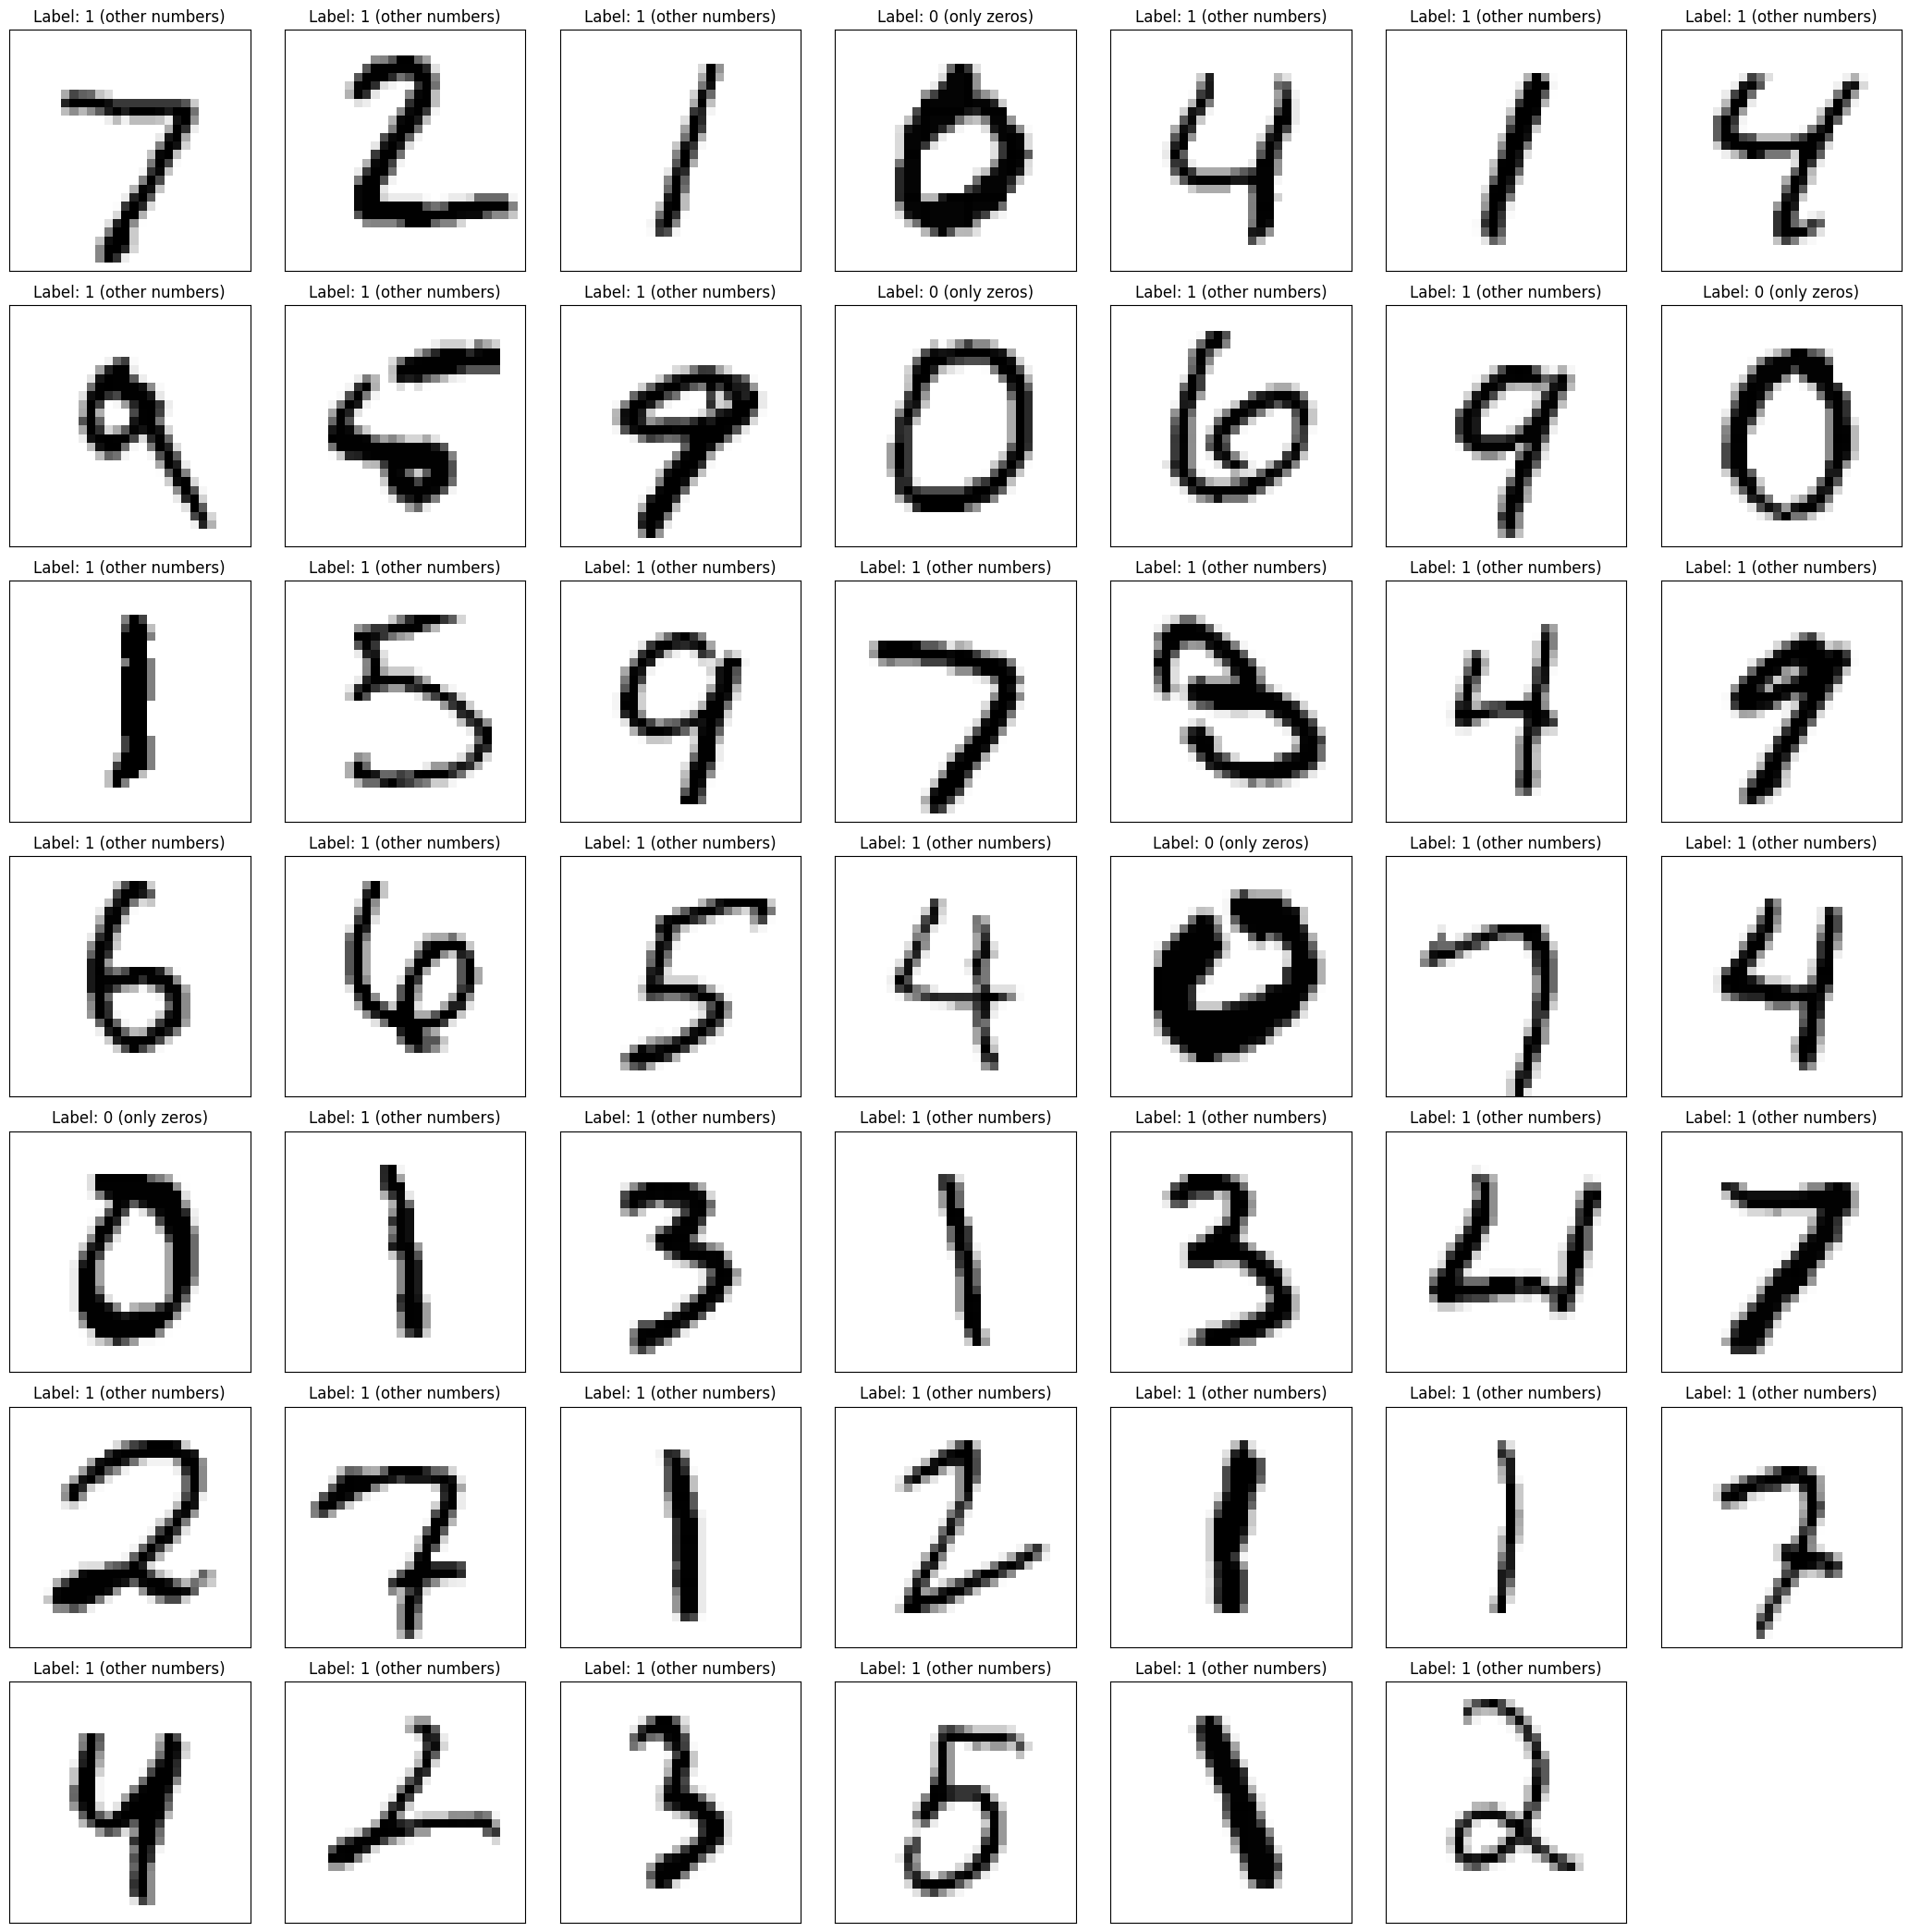

In [33]:
from utils.datasets import load_dataset, show_digit, show_digits, process_new_image, tts
from tqdm import tqdm


sample_image, sample_label = process_new_image("sample_7_900.png", 1)
data, labels = load_dataset()

# show_digit(sample_image, sample_label)
# show_digit(data[0], labels[0])
show_digits(data[:48], labels[:48])

#### Curva ROC con train alto y errores comunes

In [ ]:
from sklearn.metrics import auc
from utils.models import KNN, Linear, MLP, SVM, QDA
from utils.datasets import find_common_data
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = tts(
    data, labels, train_quantity=500
)



classifiers = {
    "KNN": KNN(),
    "Linear": Linear(),
    "MLP": MLP(),
    "SVM": SVM(probability=True)
}

pbar = tqdm(total=len(classifiers))
for name, model in classifiers.items():
    model.fit(X_train, y_train)
    fpr, tpr, thresholds = model.roc_curve(X_test, y_test)
    roc_auc = auc(fpr, tpr)

    # Calcula el umbral óptimo (punto más cercano a la esquina superior izquierda)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    # Agrega la curva ROC a la gráfica y guarda la línea dibujada
    (line,) = plt.plot(
        fpr, tpr, label=f"{name} - TH {optimal_threshold:.2f} - AUC {roc_auc:.2f}"
    )

    # Agrega el punto del umbral óptimo a la gráfica con el mismo color que la línea
    plt.plot(
        fpr[optimal_idx],
        tpr[optimal_idx],
        marker="o",
        color=line.get_color(),
    )
    pbar.update(1)

plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calcula el número de filas necesarias
n = len(classifiers)
n_rows = n // 2 + n % 2

fig, axs = plt.subplots(n_rows, 2, figsize=(15, 5 * n_rows))

for i, (name, model) in enumerate(classifiers.items()):
    # Calcula la matriz de confusión
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    # Invierte la matriz de confusión


    # Dibuja la matriz de confusión
    ax = axs[i // 2][i % 2]
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap="Blues",  annot_kws={"fontsize": 14})
    ax.set_title(f"Confussion Matrix- {name}")
    ax.set_xlabel("Prediction", fontsize=12)
    ax.set_ylabel("Real", fontsize=12)
    # Ajusta el tamaño de la fuente de las etiquetas de las clases
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)  # Ajusta el tamaño de la fuente de las etiquetas del eje X
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)  # Ajusta el tamaño de la fuente de las etiquetas del eje Y

pbar.close()


plt.tight_layout()
plt.show()

x, y = find_common_data(classifiers.values(), X_test, y_test)
show_digits(x[:24], y[:24])

#### Mostrar los 2 tipos de preprocesado

In [ ]:
# import cv2
# import scipy.io as sio


# def create_and_save_new_dataset(original_mat_file, new_mat_file, threshold):
#     data, labels = load_dataset(original_mat_file)
#     processed_data = []

#     for image in data:
#         # Convertir cada imagen en una imagen de umbral aplicado
#         img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
#         _, thresholded = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)

#         processed_data.append(thresholded)

#     processed_data = np.array(processed_data)

#     # Guardar el nuevo dataset en un archivo .mat
#     sio.savemat(new_mat_file, {"data": processed_data, "labs": labels})

# create_and_save_new_dataset("BigDigits.mat", "BigDigits_black_.mat", 100)

#### Mostrar como varia el rendimiento segun el tamaño de entrenamiento

In [ ]:
from utils.models import *

model = KNN(n_neighbors=5)
X_train, X_test, y_train, y_test = tts(data, labels, train_quantity=100)
model.fit(X_train, y_train)


print(model.evaluate_f1(X_test, y_test))
print(model.evaluate_f1_t(X_test, y_test, threshold=0.9))

In [ ]:
# from utils.models import *
# import matplotlib.pyplot as plt
# import numpy as np
# from tqdm import tqdm

# train_sizes = list(range(200, 2200, 200))

# models = {
#     "KNN 5": KNN(n_neighbors=5),
#     "KNN 3": KNN(n_neighbors=3),
#     "KNN 1": KNN(n_neighbors=1),
# }

# pbar = tqdm(total=len(models) * len(train_sizes) * 5)
# for name, model in models.items():
#     mean_scores = []  # Lista para almacenar las medias de las puntuaciones
#     pbar.set_description(f"Training {name} model")
#     for train_size in train_sizes:
#         scores = []  # Lista para almacenar las puntuaciones de cada repetición
#         for _ in range(
#             5
#         ):  # Reemplaza NUM_REPETITIONS por el número deseado de repeticiones
#             X_train, X_test, y_train, y_test = tts(
#                 data, labels, train_quantity=train_size
#             )
#             model.fit(X_train, y_train)
#             score = model.evaluate_f1(X_test, y_test)
#             scores.append(score)
#             pbar.update(1)
#         mean_score = np.mean(scores)  # Calcula la media de las puntuaciones
#         mean_scores.append(mean_score)  # Agrega la media a la lista
#     plt.plot(train_sizes, mean_scores, label=name)

# pbar.close()
# plt.xlabel("Train Size")
# plt.ylabel(
#     "Mean F1 Score"
# )  # Modifica la etiqueta del eje y para reflejar que ahora es la media
# plt.legend()
# plt.show()

#### KNN variando vecinos

In [ ]:
# from utils.models import KNN
# from utils.visualization import plot_knn_f1

# knn_f1_scores_list = []
# n_reps = 5
# neighbours = 20

# pbar = tqdm(total=n_reps * neighbours)
# for n_rep in range(n_reps):
#     X_train, X_test, y_train, y_test = tts(data, labels, train_quantity=2000)
#     knn_f1_scores = []
#     for neighbour in range(neighbours):
#         knn = KNN(n_neighbors=neighbour + 1)
#         knn.fit(X_train, y_train)
#         score = knn.evaluate_f1(X_test, y_test)
#         knn_f1_scores.append(score)
#         pbar.update(1)

#     knn_f1_scores_list.append(knn_f1_scores)

# pbar.close()
# def plot_knn_f1(f1_scores):
#     plt.figure(figsize=(10, 6))
#     # Grafica los valores de F1 para cada valor de k
#     for i, f1_score in enumerate(f1_scores):
#         plt.plot(
#             range(1, len(f1_score) + 1),
#             f1_score,
#             label=f"Repetition {i + 1}",
#         )
#     # Calcula la media de los valores de F1 para cada valor de k
#     mean_f1_scores = [sum(scores) / len(scores) for scores in zip(*f1_scores)]
#     # Grafica la media de los valores de F1
#     plt.plot(
#         range(1, len(mean_f1_scores) + 1),
#         mean_f1_scores,
#         label="Media",
#         linestyle="--",
#         color="black",
#     )
#     # Muestra la gráfica
#     plt.xticks(range(1, len(mean_f1_scores) + 1))
#     plt.legend(loc="lower right")
#     plt.xlabel("K")
#     plt.ylabel("F1")
#     plt.title("KNN F1 Scores")
#     plt.show()
# plot_knn_f1(f1_scores=knn_f1_scores_list)

#### Mostrar como varia el rendimiento de KNN con threshold y tamaño de entrenamiento

In [ ]:
from utils.models import *

model = KNN(n_neighbors=5)
X_train, X_test, y_train, y_test = tts(data, labels, train_quantity=1000)
model.fit(X_train, y_train)


print(model.evaluate_f1(X_test, y_test))
print(model.evaluate_f1_t(X_test, y_test, threshold=0.5))

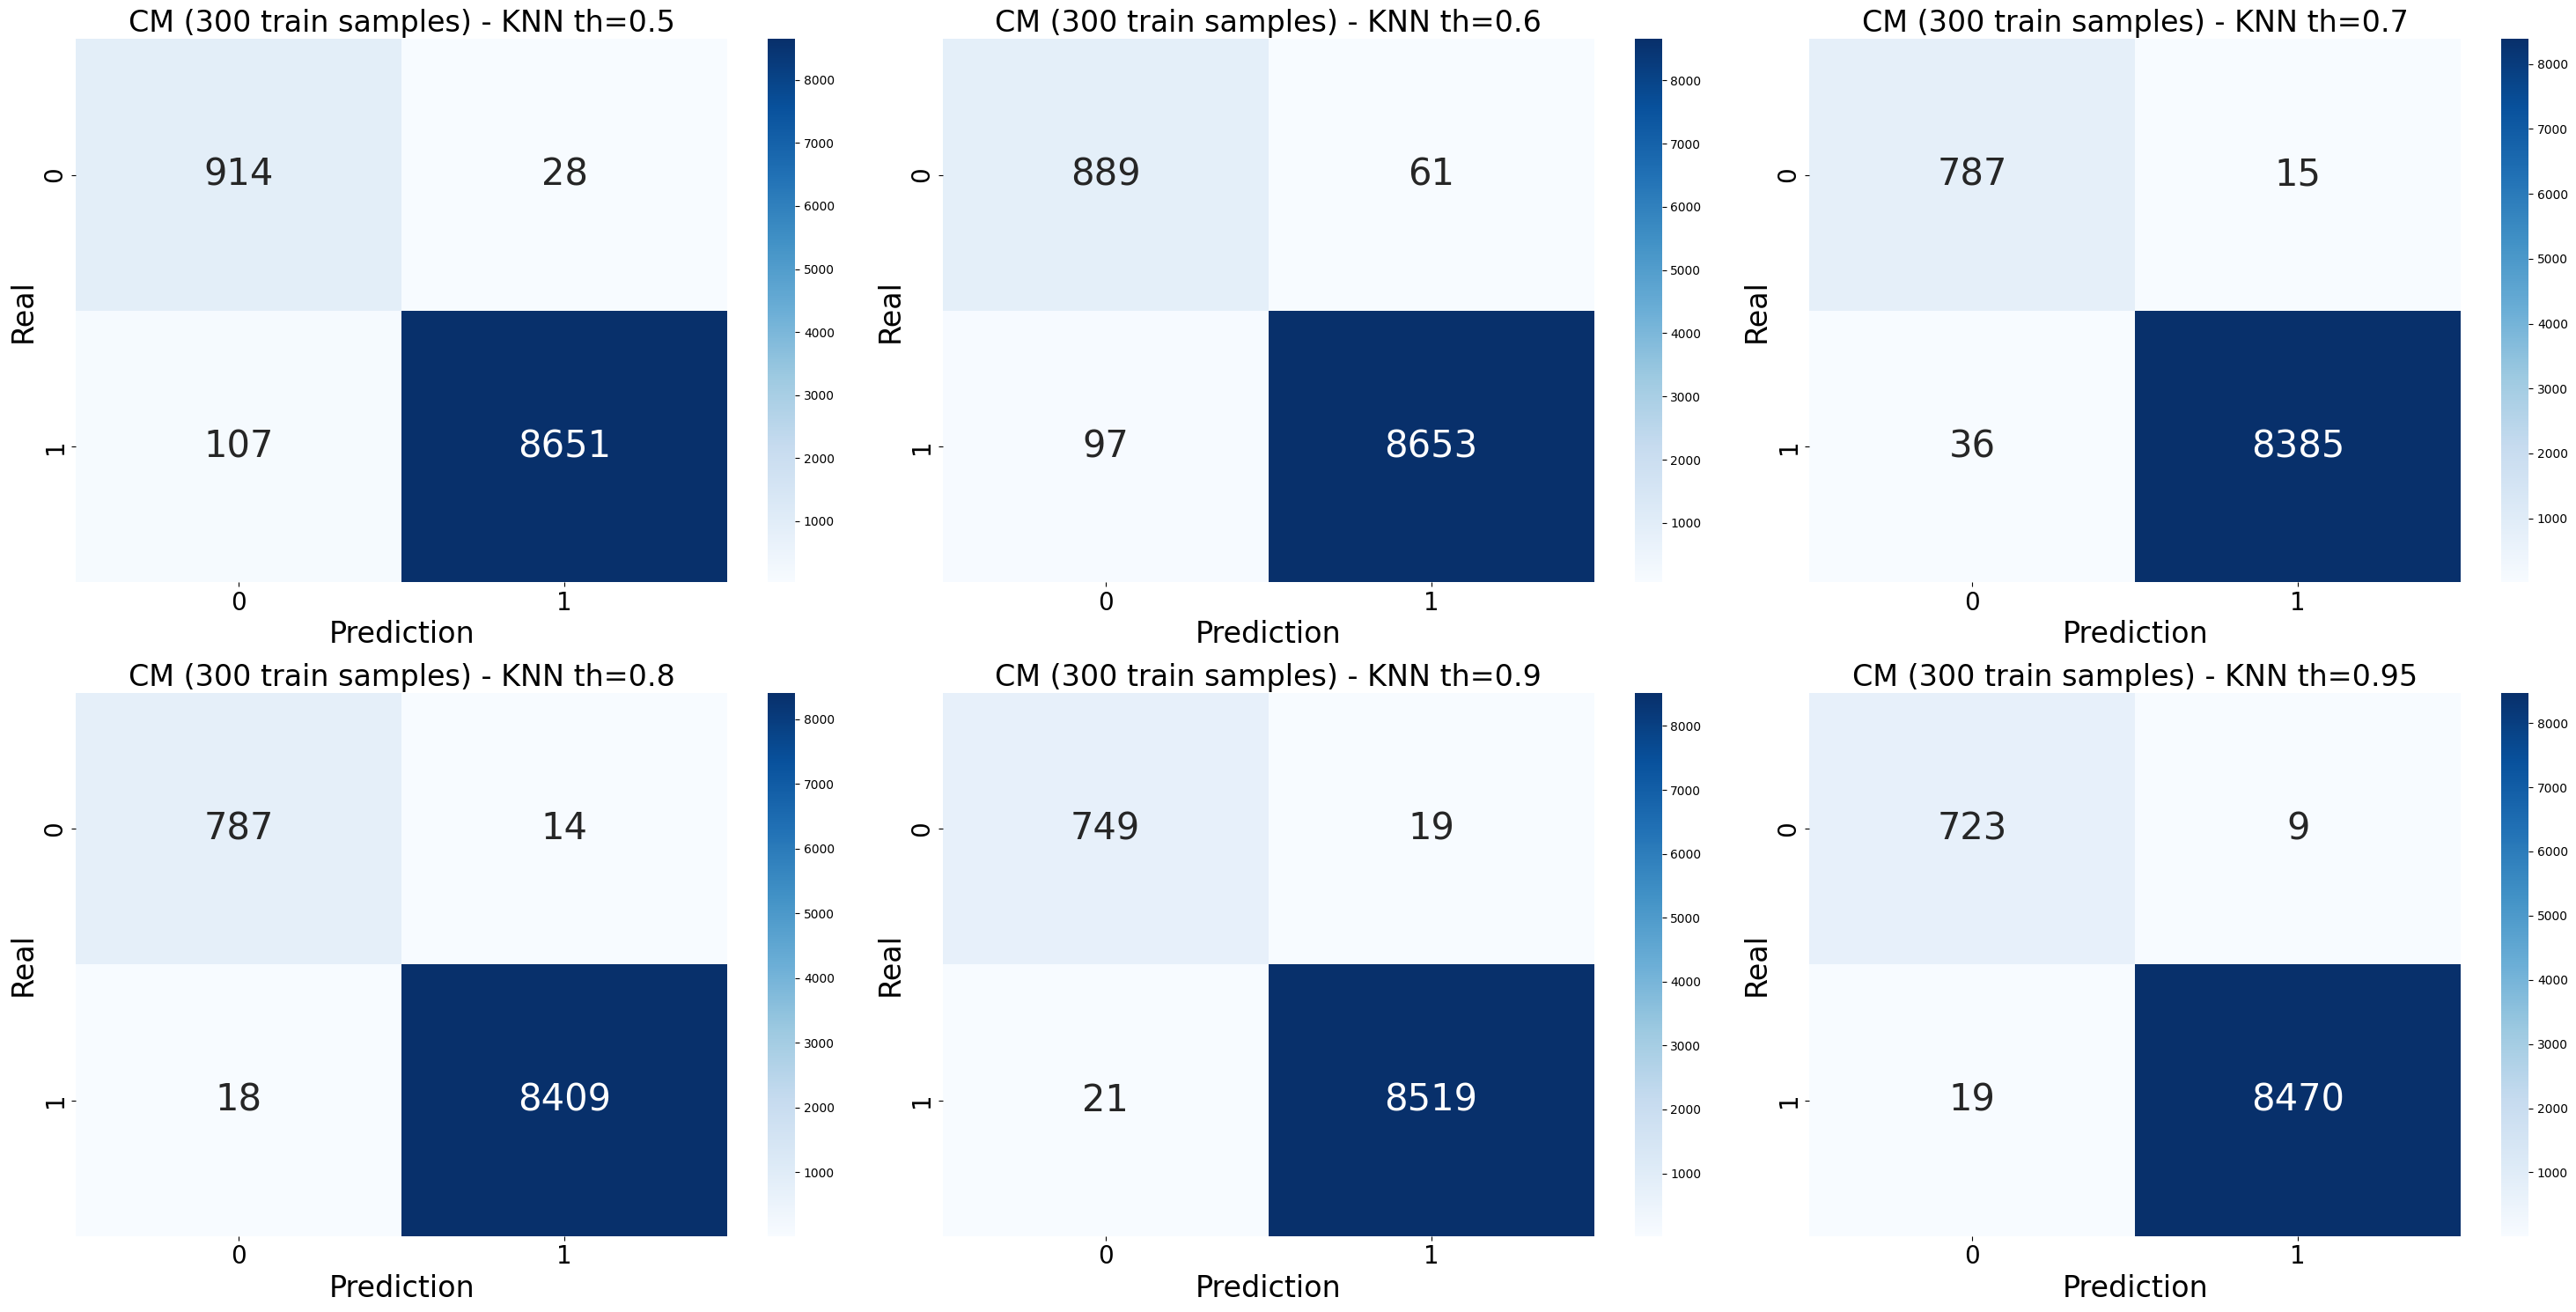

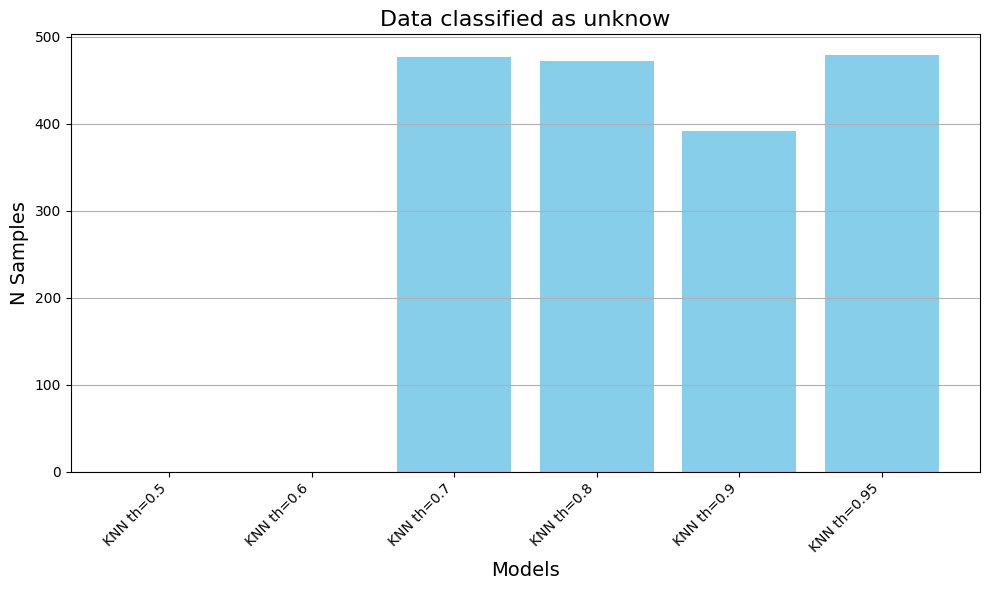

Suma de la Matriz de Confusión 1 (KNN th=0.5): 0
Suma de la Matriz de Confusión 2 (KNN th=0.6): 0
Suma de la Matriz de Confusión 3 (KNN th=0.7): 477
Suma de la Matriz de Confusión 4 (KNN th=0.8): 472
Suma de la Matriz de Confusión 5 (KNN th=0.9): 392
Suma de la Matriz de Confusión 6 (KNN th=0.95): 479


In [31]:
from utils.models import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns

# # Define the training sizes
# train_sizes = list(range(100, 1100, 100))
# num_reps = 3

# # Define the models with different K values
# models = {
#     "KNN th=0.5": {"model": KNN(n_neighbors=3), "y_test_filt": [], "y_pred_filt": []},
#     "KNN th=0.6": {"model": KNN(n_neighbors=3), "y_test_filt": [], "y_pred_filt": []},
#     "KNN th=0.7": {"model": KNN(n_neighbors=3), "y_test_filt": [], "y_pred_filt": []},
#     "KNN th=0.8": {"model": KNN(n_neighbors=3), "y_test_filt": [], "y_pred_filt": []},
#     "KNN th=0.9": {"model": KNN(n_neighbors=3), "y_test_filt": [], "y_pred_filt": []},
#     "KNN th=0.95": {"model": KNN(n_neighbors=3), "y_test_filt": [], "y_pred_filt": []},
# }

# # Define different thresholds for each model
# thresholds = {
#     "KNN th=0.5": 0.5,
#     "KNN th=0.6": 0.6,
#     "KNN th=0.7": 0.7,
#     "KNN th=0.8": 0.8,
#     "KNN th=0.9": 0.9,
#     "KNN th=0.95": 0.95,
# }

# pbar = tqdm(total=len(models) * len(train_sizes) * num_reps)
# for name, model_info in models.items():
#     model = model_info["model"]
#     mean_scores = []  # List to store mean scores
#     pbar.set_description(f"Training {name} model")
#     for train_size in train_sizes:
#         scores = []  # List to store scores for each repetition
#         for iteration in range(
#             num_reps
#         ):  # Replace NUM_REPETITIONS with the desired number of repetitions
#             X_train, X_test, y_train, y_test = tts(
#                 data, labels, train_quantity=train_size
#             )
#             model.fit(X_train, y_train)
#             threshold = thresholds[name]  # Get the threshold for the current model
#             score, y_test_filt, y_pred_filt = model.evaluate_f1_t(
#                 X_test, y_test, threshold=threshold
#             )
#             scores.append(score)
#             # Save y_test_filt and y_pred_filt for confusion matrix
#             if iteration == 2 and train_size == 300:  # Change this if you want a different repetition to be used
#                 model_info["y_test_filt"] = y_test_filt
#                 model_info["y_pred_filt"] = y_pred_filt
#             pbar.update(1)
#         mean_score = np.mean(scores)  # Calculate the mean score
#         mean_scores.append(mean_score)  # Add the mean score to the list
#     plt.plot(train_sizes, mean_scores, label=name)

# pbar.close()
# plt.xlabel("Train Size")
# plt.ylabel("Mean F1 Score")  # Modify y-axis label to reflect that it's the mean score
# plt.legend()
# plt.show()

# Calculate and plot confusion matrices
n_rows = 3
n_cols = 2

fig, axs = plt.subplots(n_cols, n_rows, figsize=(30, 5 * n_rows))

# Flatten the array of axes for easier iteration
axs = axs.flatten()

# Lista para almacenar las sumas de las matrices de confusión
cm_sum_list = []

for i, (name, model_info) in enumerate(models.items()):
    y_test_filt = model_info["y_test_filt"]
    y_pred_filt = model_info["y_pred_filt"]
    # Calculate the confusion matrix
    cm = confusion_matrix(y_test_filt, y_pred_filt)
    
    # Calcular la suma de los valores de la matriz de confusión
    cm_sum = cm.sum()
    
    # Almacenar la suma en la lista
    cm_sum_list.append(9700 - cm_sum)

    # Plot the confusion matrix
    ax = axs[i]
    sns.heatmap(
        cm, annot=True, fmt="d", ax=ax, cmap="Blues", annot_kws={"fontsize": 30}
    )
    ax.set_title(f"CM (300 train samples) - {name}", fontsize=24)
    ax.set_xlabel("Prediction", fontsize=24)
    ax.set_ylabel("Real", fontsize=24)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=20)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)

plt.tight_layout()
plt.show()

# Graficar las sumas de las matrices de confusión
plt.figure(figsize=(10, 6))
model_names = list(models.keys())
plt.bar(model_names, cm_sum_list, color='skyblue')
plt.xlabel('Models', fontsize=14)
plt.ylabel('N Samples', fontsize=14)
plt.title('Data classified as unknow', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

# Mostrar las sumas de las matrices de confusión
for idx, cm_sum in enumerate(cm_sum_list):
    print(f"Suma de la Matriz de Confusión {idx + 1} ({model_names[idx]}): {cm_sum}")